In [1]:
import os
from skimage import io,util
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np

In [2]:
images = []
segmented_map = []
img_filenames = 'archive/tiff/train'
img_segmented_filenames = 'archive/tiff/train_labels'


for filename in os.listdir(img_segmented_filenames):
    image = io.imread(os.path.join(img_filenames, filename+'f'))
    segmented_image = io.imread(os.path.join(img_segmented_filenames, filename))
    images.append(image)
    segmented_map.append(segmented_image)

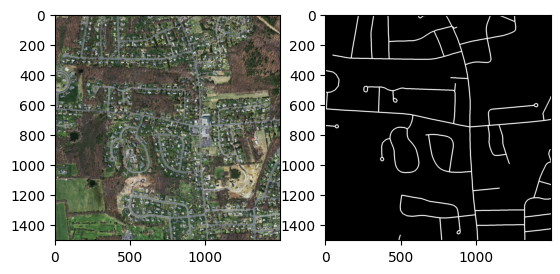

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(images[9])
plt.subplot(1,2,2)
plt.imshow(segmented_map[9], cmap='gray')
plt.show()

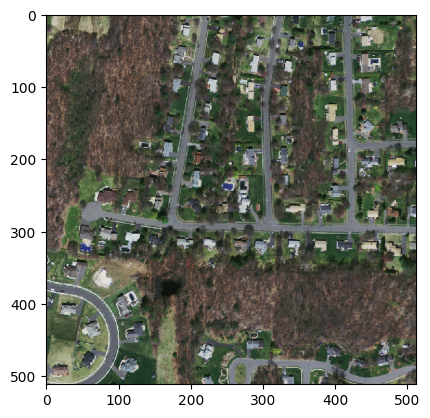

In [5]:
# Dividing images to 4 parts of 512x512

test_image = Image.open('archive/tiff/50pics/10228705_15.tiff')
width, height = 512, 512
num_cols = test_image.width // width
num_rows = test_image.height // height
num_images = num_cols * num_rows

small_images = []
for row in range(num_rows):
    for col in range(num_cols):
        left = col * width
        upper = row * height
        right = left + width
        lower = upper + height
        small_images.append(test_image.crop((left, upper, right, lower)))

plt.imshow(small_images[0])
plt.show()

In [7]:
# Bilateral filtering to enhance the edges
import cv2
image = cv2.imread('archive/tiff/50pics/10228705_15.tiff')

# Apply the bilateral filter
bilateral_filtered = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Show the original and filtered images
cv2.imshow('Original Image', image)
cv2.imshow('Bilateral Filtered Image', bilateral_filtered)
cv2.waitKey(0)
cv2.destroyAllWindows()

# plt.subplot(1,2,1)
# plt.imshow(image)
# plt.title('Original Image')
# plt.subplot(1,2,2)
# plt.imshow(bilateral_filtered)
# plt.title('Bilateral Filtered Image')
# plt.show()

In [27]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU, Activation
from keras.models import Model
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Generator (U-Net)
def define_generator(input_shape=(512,512,3)):
    init = RandomNormal(stddev=0.2)
    inputs = Input(shape=input_shape)
    
    # Encoding path
    conv1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
 
    conv2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv1)
    conv2 = BatchNormalization()(conv2, training=True)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    
    conv3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv2)
    conv3 = BatchNormalization()(conv3, training=True)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv3)
    conv4 = BatchNormalization()(conv4, training=True)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    
    conv5 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv4)
    conv5 = BatchNormalization()(conv5, training=True)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    conv6 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv5)
    conv6 = BatchNormalization()(conv6, training=True)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    
    conv7 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv6)
    conv7 = BatchNormalization()(conv7, training=True)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    
    # Bottleneck Layer
    
    bottle = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv7)
    bottle = Activation('relu')(bottle)
    
    # Decoding path
    convT7 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(bottle)
    convT7 = BatchNormalization()(convT7, training=True)
    convT7 = Dropout(0.5)(convT7, training=True)
    convT7 = Concatenate()([convT7, conv7])
    convT7 = Activation('relu')(convT7)
    
    convT6 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT7)
    convT6 = BatchNormalization()(convT6, training=True)
    convT6 = Dropout(0.5)(convT6, training=True)
    convT6 = Concatenate()([convT6, conv6])
    convT6 = Activation('relu')(convT6)

    convT5 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT6)
    convT5 = BatchNormalization()(convT5, training=True)
    convT5 = Dropout(0.5)(convT5, training=True)
    convT5 = Concatenate()([convT5, conv5])
    convT5 = Activation('relu')(convT5)
    
    convT4 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT5)
    convT4 = BatchNormalization()(convT4, training=True)
    convT4 = Concatenate()([convT4, conv4])
    convT4 = Activation('relu')(convT4)
    
    convT3 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT4)
    convT3 = BatchNormalization()(convT3, training=True)
    convT3 = Concatenate()([convT3, conv3])
    convT3 = Activation('relu')(convT3)
    
    convT2 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT3)
    convT2 = BatchNormalization()(convT2, training=True)
    convT2 = Concatenate()([convT2, conv2])
    convT2 = Activation('relu')(convT2)
    
    convT1 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT2)
    convT1 = BatchNormalization()(convT1, training=True)
    convT1 = Concatenate()([convT1, conv1])
    convT1 = Activation('relu')(convT1)   
    
    out = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(convT1)
    out = Activation('tanh')(out)
    
    generator = Model(inputs=inputs, outputs=out)
    
    return generator

In [4]:
# Discriminator (CNN)
def define_discriminator(image_shape):
    
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=(512,512,1))
    merged = Concatenate()([in_src_image,in_target_image])
    
    conv1 = Conv2D(64, (4,4), strides=(2,2),padding='same', kernel_initializer=init)(merged)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    
    conv3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    
    conv5 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    conv6 = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    
    out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(conv6)
    out = Activation('sigmoid')(out)
    
    discriminator = Model(inputs=[in_src_image,in_target_image], outputs=out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    
    return discriminator

In [5]:
def define_gan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		layer.trainable = False
            
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])
    
	opt = Adam(learning_rate=0.0002, beta_1=0.5)

	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [6]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [7]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [8]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, n_patch=512):
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    g_model.save_weights('generator_model.h5')

In [31]:
from skimage import io
import cv2
import numpy as np

train_path = 'roadsdb/enhanced_images'
train_labels_path = 'roadsdb/new_train_labels'

og_images, label_images = list(),list()

def load_images():

    for file in os.listdir(train_labels_path):
        img_path = os.path.join(train_path, file+'f')
        img = io.imread(img_path)
        og_images.append(img)
    
        label_path = os.path.join(train_labels_path,file)
        label_img = io.imread(label_path)
        label_images.append(label_img)
    
    return [np.asarray(og_images), np.asarray(label_images)]

[src_images, tar_images] = load_images()

# train(d_model, g_model, gan_model, datset)

In [28]:
image_shape = (512,512,3)
g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

In [38]:
data = [src_images, tar_images]
def preprocess_data(data):
    
	X1, X2 = data[0], data[1]
    
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [33]:
from datetime import datetime 
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, n_epochs=2, n_batch=1)
stop1 = datetime.now()
execution_time = stop1-start1
print("Execution time is: ", execution_time)

>1, d1[0.003] d2[0.004] g[15.847]
>2, d1[0.003] d2[0.003] g[9.722]
>3, d1[0.002] d2[0.004] g[21.553]
>4, d1[0.003] d2[0.003] g[6.602]
>5, d1[0.002] d2[0.003] g[12.288]
>6, d1[0.004] d2[0.004] g[6.171]
>7, d1[0.002] d2[0.004] g[17.550]
>8, d1[0.002] d2[0.004] g[22.674]
>9, d1[0.002] d2[0.003] g[15.504]
>10, d1[0.002] d2[0.004] g[12.458]
>11, d1[0.002] d2[0.004] g[9.106]
>12, d1[0.002] d2[0.004] g[15.805]
>13, d1[0.002] d2[0.004] g[20.087]
>14, d1[0.002] d2[0.004] g[10.908]
>15, d1[0.002] d2[0.004] g[21.479]
>16, d1[0.002] d2[0.004] g[12.359]
>17, d1[0.002] d2[0.003] g[19.030]
>18, d1[0.002] d2[0.003] g[16.104]
>19, d1[0.002] d2[0.002] g[21.286]
>20, d1[0.002] d2[0.004] g[19.559]
>21, d1[0.003] d2[0.004] g[8.386]
>22, d1[0.002] d2[0.005] g[22.648]
>23, d1[0.002] d2[0.003] g[14.629]
>24, d1[0.002] d2[0.003] g[8.900]
>25, d1[0.002] d2[0.004] g[16.419]
>26, d1[0.002] d2[0.004] g[17.323]
>27, d1[0.002] d2[0.003] g[7.609]
>28, d1[0.002] d2[0.005] g[20.819]
>29, d1[0.002] d2[0.004] g[11.577]
>

>233, d1[0.001] d2[0.014] g[16.065]
>234, d1[0.001] d2[0.015] g[19.064]
>235, d1[0.001] d2[0.013] g[9.783]
>236, d1[0.001] d2[0.010] g[15.098]
>237, d1[0.001] d2[0.011] g[8.362]
>238, d1[0.001] d2[0.010] g[19.763]
>239, d1[0.001] d2[0.011] g[8.133]
>240, d1[0.001] d2[0.011] g[17.465]
>241, d1[0.001] d2[0.012] g[37.449]
>242, d1[0.001] d2[0.011] g[27.332]
>243, d1[0.001] d2[0.010] g[9.946]
>244, d1[0.001] d2[0.008] g[12.452]
>245, d1[0.001] d2[0.011] g[14.385]
>246, d1[0.001] d2[0.010] g[25.408]
>247, d1[0.001] d2[0.009] g[27.486]
>248, d1[0.001] d2[0.009] g[11.588]
>249, d1[0.001] d2[0.010] g[28.538]
>250, d1[0.001] d2[0.009] g[24.336]
>251, d1[0.001] d2[0.009] g[9.038]
>252, d1[0.001] d2[0.010] g[25.426]
>253, d1[0.001] d2[0.010] g[12.422]
>254, d1[0.001] d2[0.014] g[26.213]
>255, d1[0.001] d2[0.013] g[9.995]
>256, d1[0.001] d2[0.011] g[14.328]
>257, d1[0.001] d2[0.011] g[26.798]
>258, d1[0.001] d2[0.009] g[14.674]
>259, d1[0.001] d2[0.010] g[10.464]
>260, d1[0.001] d2[0.009] g[13.410

>463, d1[0.001] d2[0.011] g[14.209]
>464, d1[0.001] d2[0.013] g[17.119]
>465, d1[0.001] d2[0.012] g[23.546]
>466, d1[0.001] d2[0.008] g[12.374]
>467, d1[0.001] d2[0.009] g[9.339]
>468, d1[0.001] d2[0.010] g[15.388]
>469, d1[0.001] d2[0.007] g[11.058]
>470, d1[0.001] d2[0.008] g[17.531]
>471, d1[0.001] d2[0.010] g[13.486]
>472, d1[0.001] d2[0.010] g[8.969]
>473, d1[1.476] d2[2.285] g[0.797]
>474, d1[0.018] d2[0.272] g[6.620]
>475, d1[0.072] d2[0.111] g[4.158]
>476, d1[0.030] d2[0.068] g[15.349]
>477, d1[0.034] d2[0.061] g[8.859]
>478, d1[0.038] d2[0.063] g[12.129]
>479, d1[0.020] d2[0.048] g[14.291]
>480, d1[0.011] d2[0.036] g[17.090]
>481, d1[0.010] d2[0.032] g[8.288]
>482, d1[0.009] d2[0.023] g[18.445]
>483, d1[0.009] d2[0.031] g[10.379]
>484, d1[0.079] d2[0.053] g[4.018]
>485, d1[0.008] d2[0.037] g[13.839]
>486, d1[0.008] d2[0.033] g[22.158]
>487, d1[0.006] d2[0.032] g[20.668]
>488, d1[0.009] d2[0.021] g[9.955]
>489, d1[0.007] d2[0.021] g[10.108]
>490, d1[0.009] d2[0.023] g[11.062]
>

>693, d1[0.004] d2[0.011] g[4.999]
>694, d1[0.001] d2[0.009] g[14.540]
>695, d1[0.002] d2[0.010] g[18.595]
>696, d1[0.001] d2[0.008] g[16.186]
>697, d1[1.929] d2[0.048] g[2.359]
>698, d1[0.001] d2[0.049] g[5.664]
>699, d1[0.001] d2[0.034] g[23.101]
>700, d1[0.001] d2[0.026] g[25.848]
>701, d1[0.001] d2[0.021] g[12.202]
>702, d1[0.001] d2[0.023] g[13.537]
>703, d1[0.001] d2[0.024] g[16.631]
>704, d1[0.001] d2[0.022] g[25.584]
>705, d1[0.001] d2[0.018] g[17.496]
>706, d1[0.001] d2[0.017] g[13.866]
>707, d1[1.709] d2[0.050] g[2.123]
>708, d1[0.001] d2[0.063] g[6.735]
>709, d1[0.001] d2[0.071] g[5.376]
>710, d1[0.001] d2[0.048] g[44.195]
>711, d1[0.001] d2[0.046] g[22.338]
>712, d1[0.001] d2[0.043] g[13.822]
>713, d1[0.001] d2[0.033] g[11.373]
>714, d1[0.001] d2[0.033] g[11.416]
>715, d1[0.001] d2[0.035] g[15.374]
>716, d1[0.001] d2[0.028] g[16.213]
>717, d1[0.001] d2[0.024] g[8.317]
>718, d1[0.001] d2[0.023] g[14.512]
>719, d1[0.001] d2[0.021] g[8.093]
>720, d1[0.001] d2[0.023] g[25.893]


>922, d1[0.002] d2[0.008] g[6.663]
>923, d1[0.001] d2[0.009] g[23.418]
>924, d1[0.002] d2[0.007] g[38.124]
>925, d1[0.001] d2[0.009] g[20.246]
>926, d1[0.002] d2[0.008] g[9.302]
>927, d1[0.001] d2[0.008] g[22.136]
>928, d1[0.001] d2[0.008] g[22.479]
>929, d1[0.001] d2[0.008] g[18.411]
>930, d1[0.001] d2[0.007] g[13.988]
>931, d1[0.001] d2[0.008] g[11.213]
>932, d1[0.001] d2[0.007] g[17.901]
>933, d1[0.001] d2[0.008] g[24.704]
>934, d1[0.001] d2[0.008] g[24.172]
>935, d1[0.002] d2[0.009] g[6.092]
>936, d1[0.001] d2[0.008] g[18.500]
>937, d1[0.001] d2[0.008] g[15.940]
>938, d1[0.001] d2[0.008] g[8.369]
>939, d1[0.001] d2[0.008] g[10.625]
>940, d1[0.001] d2[0.007] g[16.432]
>941, d1[0.001] d2[0.008] g[19.140]
>942, d1[0.001] d2[0.008] g[28.776]
>943, d1[0.002] d2[0.007] g[5.899]
>944, d1[0.001] d2[0.008] g[14.651]
>945, d1[0.001] d2[0.007] g[10.174]
>946, d1[0.001] d2[0.008] g[7.825]
>947, d1[0.002] d2[0.008] g[8.782]
>948, d1[0.001] d2[0.007] g[13.576]
>949, d1[0.001] d2[0.007] g[28.804]

>1147, d1[0.001] d2[0.012] g[15.156]
>1148, d1[0.001] d2[0.011] g[17.463]
>1149, d1[1.879] d2[0.029] g[2.596]
>1150, d1[0.001] d2[0.037] g[11.698]
>1151, d1[0.001] d2[0.031] g[8.757]
>1152, d1[0.001] d2[0.029] g[9.175]
>1153, d1[0.001] d2[0.031] g[13.499]
>1154, d1[0.001] d2[0.024] g[14.248]
>1155, d1[0.001] d2[0.025] g[12.001]
>1156, d1[0.001] d2[0.026] g[4.809]
>1157, d1[0.001] d2[0.024] g[18.041]
>1158, d1[0.001] d2[0.022] g[18.593]
>1159, d1[0.001] d2[0.020] g[18.742]
>1160, d1[0.001] d2[0.021] g[14.854]
>1161, d1[0.001] d2[0.019] g[14.885]
>1162, d1[0.001] d2[0.019] g[14.946]
>1163, d1[0.001] d2[0.019] g[16.741]
>1164, d1[0.001] d2[0.017] g[8.636]
>1165, d1[0.001] d2[0.018] g[15.695]
>1166, d1[0.001] d2[0.018] g[15.631]
>1167, d1[0.001] d2[0.016] g[11.574]
>1168, d1[0.001] d2[0.019] g[17.495]
>1169, d1[0.001] d2[0.016] g[13.844]
>1170, d1[0.002] d2[0.014] g[45.216]
>1171, d1[0.002] d2[0.014] g[4.505]
>1172, d1[0.001] d2[0.016] g[18.294]
>1173, d1[0.002] d2[0.014] g[10.263]
>1174, 

>1370, d1[0.002] d2[0.009] g[9.628]
>1371, d1[0.002] d2[0.008] g[13.017]
>1372, d1[0.002] d2[0.009] g[20.561]
>1373, d1[0.002] d2[0.009] g[19.551]
>1374, d1[0.002] d2[0.009] g[11.241]
>1375, d1[0.002] d2[0.008] g[24.622]
>1376, d1[0.002] d2[0.008] g[22.975]
>1377, d1[0.002] d2[0.008] g[18.235]
>1378, d1[0.002] d2[0.008] g[12.101]
>1379, d1[0.002] d2[0.008] g[12.635]
>1380, d1[0.002] d2[0.008] g[11.530]
>1381, d1[0.002] d2[0.008] g[16.446]
>1382, d1[0.002] d2[0.008] g[20.332]
>1383, d1[1.000] d2[2.531] g[0.710]
>1384, d1[0.042] d2[0.911] g[6.264]
>1385, d1[0.284] d2[0.562] g[20.170]
>1386, d1[0.366] d2[0.272] g[8.428]
>1387, d1[0.427] d2[0.208] g[11.877]
>1388, d1[0.229] d2[0.199] g[13.334]
>1389, d1[0.173] d2[0.191] g[11.030]
>1390, d1[0.126] d2[0.149] g[6.557]
>1391, d1[0.103] d2[0.121] g[14.478]
>1392, d1[0.990] d2[0.202] g[1.130]
>1393, d1[0.049] d2[0.218] g[8.792]
>1394, d1[0.053] d2[0.157] g[11.961]
>1395, d1[0.146] d2[0.137] g[2.838]
>1396, d1[0.046] d2[0.115] g[13.206]
>1397, d1

Execution time is:  0:08:51.982322


(512, 512, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

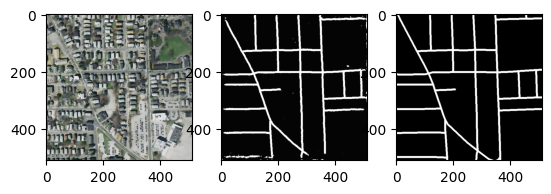

In [29]:
from matplotlib import pyplot
import cv2
import numpy as np

image_path = 'roadsdb/enhanced_images/2_17578885_15.tiff'
ground_path = 'roadsdb/new_train_labels/2_17578885_15.tif'

ground_img = cv2.imread(ground_path)

g_model.load_weights('generator_model (1).h5')
prediction_image = cv2.imread(image_path)
prediction_image = cv2.cvtColor(prediction_image, cv2.COLOR_BGR2RGB)
input_tensor = (prediction_image - 127.5) / 127.5
print(input_tensor.shape)
predicted_img = g_model.predict(input_tensor.reshape((1, 512, 512, 3)))
predicted_img = np.squeeze(predicted_img, axis=0)


pyplot.subplot(1,3,1)
pyplot.imshow(prediction_image)
pyplot.subplot(1,3,2)
pyplot.imshow(predicted_img, cmap='gray')
pyplot.subplot(1,3,3)
pyplot.imshow(ground_img)
pyplot.show

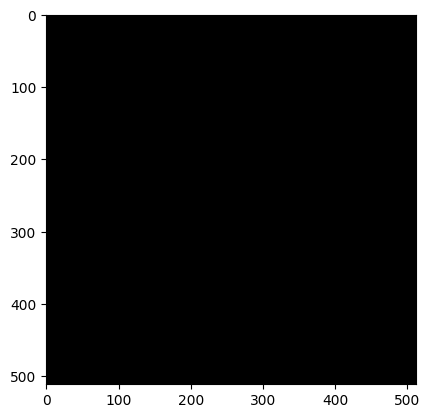

In [20]:
import cv2

# Set a threshold value (between 0 and 255)
threshold_value = 230



# Convert all pixels that are not white or below the threshold to black
mask = cv2.threshold(predicted_img[..., 0], threshold_value, 255, cv2.THRESH_BINARY)[1]
mask[np.where(predicted_img[..., 0] < 240)] = 0

plt.imshow(mask, cmap='gray')
plt.show()